In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 26.9 MB/s 


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 31.9 MB/s 
     |████████████████████████████████| 7.6 MB 58.1 MB/s 
     |████████████████████████████████| 163 kB 74.8 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import os
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import tensorflow_datasets as tfds
import re
import string
import nltk
from nltk.corpus import stopwords
import transformers
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig,TFBertModel

In [ ]:
train, test = tfds.load('yelp_polarity_reviews', split=['train','test'], shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/560000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/yelp_polarity_reviews/0.2.0.incompleteAQ84F2/yelp_polarity_reviews-train.tfrec…

Generating test examples...:   0%|          | 0/38000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/yelp_polarity_reviews/0.2.0.incompleteAQ84F2/yelp_polarity_reviews-test.tfreco…

Dataset yelp_polarity_reviews downloaded and prepared to ~/tensorflow_datasets/yelp_polarity_reviews/0.2.0. Subsequent calls will reuse this data.


In [ ]:
train_df = tfds.as_dataframe(train.take(20000)) # importing complete Dataset led to exhaustion of RAM
test_df = tfds.as_dataframe(test.take(500))

In [ ]:
print(train_df.shape)
print(test_df.shape)

(20000, 2)
(500, 2)


In [ ]:
train_df['label'].value_counts()

1    10049
0     9951
Name: label, dtype: int64

In [ ]:
train_df.head()

label                                               text
0      1  b"If you want to be on the strip, this isn't t...
1      1  b"A great place to shop in Vegas, one of my fa...
2      1  b"First time trying this place out...ordered t...
3      0  b"It was bad. My nails are ruined. I asked for...
4      1  b'My wife ordered bun tom thit nuong, also kno...

In [ ]:
print("Positive Review example :",train_df[train_df['label']==1]['text'].values[0])
print("Negative Review example :",train_df[train_df['label']==0]['text'].values[0])

Positive Review example : b"If you want to be on the strip, this isn't the place for you.  I have never stayed on the strip in Vegas and like the flexibility to check out different places.  I also love staying in condos while on vacation.  We often travel in a group of 5, so having apartment-style lodging is much more convenient (not to mention cheaper) than having multiple hotel rooms or one large suite.  \\n\\nI have stayed here on two occasions and been very satisfied both times.  Ask for a strip-view room, though, or you'll be looking out your window at an airport runway!"
Negative Review example : b"It was bad. My nails are ruined. I asked for purple and sparkles and they gave me nothing near that. I got too many sparkles. They didn't even ask me if I liked it. My friend who went with me got 2 coats and a top. I got not even a full 1st coat it was the worst. I am going somewhere else tomorrow. I had the worse time ever. Looks like Rainbow nails will not be seeing  me there any tim

# Text Preprocessing

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z\s]|','',text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def text_preprocessing(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    print(tokenized_text)
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(remove_stopwords)
    return combined_text

In [ ]:
train_df['text_clean'] = train_df['text'].apply(str).apply(lambda x: text_preprocessing(x[1:]))
test_df['text_clean'] = test_df['text'].apply(str).apply(lambda x: text_preprocessing(x[1:]))

Streaming output truncated to the last 5000 lines.
['i', 'can', 'overcome', 'the', 'hipster', 'sneer', 'and', 'accept', 'that', 'i', 'am', 'an', 'uncool', 'blemish', 'in', 'a', 'world', 'full', 'of', 'cutoff', 'corduroys', 'and', 'patterned', 'leggings', 'what', 'i', 'cannot', 'and', 'will', 'not', 'get', 'over', 'is', 'an', 'unapologetic', 'staff', 'whose', 'epic', 'error', 'led', 'to', 'me', 'breaking', 'years', 'of', 'meatless', 'eating', 'because', 'of', 'an', 'order', 'mishapnni', 'ordered', 'the', 'red', 'pepper', 'tomato', 'quiche', 'after', 'minutes', 'waiting', 'for', 'the', 'quiche', 'to', 'warm', 'in', 'what', 'appeared', 'to', 'be', 'a', 'degree', 'oven', 'i', 'double', 'checked', 'to', 'make', 'sure', 'my', 'name', 'was', 'on', 'the', 'plate', 'at', 'the', 'counter', 'when', 'i', 'dug', 'in', 'for', 'the', 'first', 'bite', 'a', 'wave', 'of', 'nausea', 'and', 'panic', 'washed', 'over', 'my', 'after', 'realizing', 'this', 'was', 'a', 'piece', 'of', 'the', 'bacon', 'spinach',

In [ ]:
train_df.head()

label                                               text  \
0      1  b"If you want to be on the strip, this isn't t...   
1      1  b"A great place to shop in Vegas, one of my fa...   
2      1  b"First time trying this place out...ordered t...   
3      0  b"It was bad. My nails are ruined. I asked for...   
4      1  b'My wife ordered bun tom thit nuong, also kno...   

                                          text_clean  
0  want strip isnt place never stayed strip vegas...  
1  great place shop vegas one favorite places bre...  
2  first time trying place outordered aloha chick...  
3  bad nails ruined asked purple sparkles gave no...  
4  wife ordered bun tom thit nuong also known old...

# BERT

In [ ]:
model_name = "bert-base-uncased"
max_length = 64 # increasing the maximum sequence length led to OOM error tried 256,512,1024

In [ ]:
tokenizer = BertTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
(train,val)=train_test_split(train_df, test_size=0.1)

In [ ]:
val.head()

label                                               text  \
863        0  b'Blondies is a tough sell on me.  I like play...   
5614       0  b"As I posted in my tip, I won't be back. I do...   
11145      1  b'While out in PIT, I checked out this Gastro ...   
4817       0  b'Upon my visit to Heist Brewery, I expected a...   
16775      0  b"Figured I'd give them another shot, as the l...   

                                              text_clean  
863    blondies tough sell like playing beer pong cro...  
5614   posted tip wont back dont eat meat wasnt mood ...  
11145  pit checked gastro pub food restrictions staff...  
4817   upon visit heist brewery expected casual vibe ...  
16775  figured id give another shot location convenie...

In [ ]:
train = train.reset_index().drop('index',axis=1)
val = val.reset_index().drop('index',axis=1)
test_df = test_df.reset_index().drop('index',axis=1)

In [ ]:
train.head()

label                                               text  \
0      0  b'i thought I loved the place, until I decided...   
1      0  b'This place has a lot of potential, but certa...   
2      1  b"I purchased my first handgun here and it was...   
3      0  b'The place is very nice inside. We came to ea...   
4      0  b'This place says they have both DirecTV and C...   

                                          text_clean  
0  thought loved place decided straighten hair de...  
1  place lot potential certainly misses mark food...  
2  purchased first handgun pretty painless proces...  
3  place nice inside came eat left still hungry f...  
4  place says directv cox draw people interested ...

In [ ]:
def bert_encode(data,maximum_length) :
    input_ids = []
    attention_masks = []
  

    for i in range(len(data.text_clean)):
        encoded = tokenizer.encode_plus(
        data.text_clean[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        return_attention_mask=True,
      )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
train_input_ids,train_attention_masks = bert_encode(train,max_length)
val_input_ids,val_attention_masks = bert_encode(val,max_length)
test_input_ids,test_attention_masks = bert_encode(test_df,max_length)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
train_input_ids.dtype

dtype('int64')

In [ ]:
def create_model(model):
    input_ids = tf.keras.Input(shape=(64,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(64,),dtype='int32')
    input_ids.dtype
    output = model([input_ids,attention_masks])
    output = output[1]
    
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)

    output = tf.keras.layers.Dense(1,activation='sigmoid')(output) # since this is a base model to convert it to classification model added extra layers
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-6), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model=TFBertModel.from_pretrained(model_name, num_labels=2)

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
model = create_model(model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 64,                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, verbose=0,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
)

In [ ]:
early_stop=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

In [ ]:
history_bert = model.fit([train_input_ids,train_attention_masks],train['label'],validation_data=([val_input_ids,val_attention_masks],val['label']), epochs=15,batch_size=64, callbacks=[early_stop,reduce_lr])

Epoch 1/15
282/282 [==============================] - 251s 830ms/step - loss: 0.6237 - accuracy: 0.6443 - val_loss: 0.4312 - val_accuracy: 0.8095 - lr: 1.0000e-06
Epoch 2/15
282/282 [==============================] - 232s 822ms/step - loss: 0.4134 - accuracy: 0.8210 - val_loss: 0.3380 - val_accuracy: 0.8545 - lr: 1.0000e-06
Epoch 3/15
282/282 [==============================] - 232s 824ms/step - loss: 0.3594 - accuracy: 0.8497 - val_loss: 0.3288 - val_accuracy: 0.8575 - lr: 1.0000e-06
Epoch 4/15
161/282 [================>.............] - ETA: 1:36 - loss: 0.3383 - accuracy: 0.8600

In [ ]:
y_hat = model.predict([test_input_ids,test_attention_masks])
y_pred=[]
for x in y_hat:
  if x<0.5:
    y_pred.append(0)
  else:
    y_pred.append(1)

Text(0.5, 1.0, 'Confusion Matrix - Decision Tree')

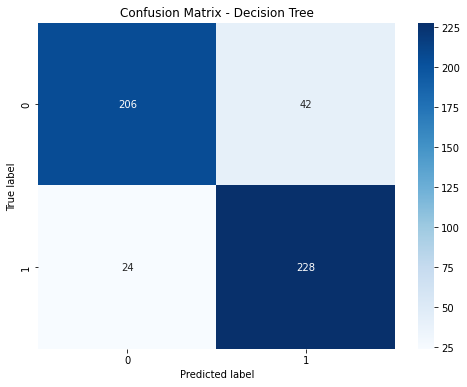

In [ ]:
plt.figure(figsize=(8,6))
ConfMatrix = confusion_matrix(test_df['label'],y_pred)
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix")

# XLNET

In [ ]:
from transformers import XLNetTokenizer, TFXLNetForSequenceClassification

In [ ]:
model_name = 'xlnet-base-cased'

In [ ]:
tokenizer_xlnet = XLNetTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [ ]:
def xlnet_encode(data,maximum_length) :
    input_ids = []
    attention_masks = []
  

    for i in range(len(data.text_clean)):
        encoded = tokenizer_xlnet.encode_plus(
        data.text_clean[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        return_attention_mask=True,
      )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
train_input_ids,train_attention_masks = xlnet_encode(train,64)
val_input_ids,val_attention_masks = xlnet_encode(val,64)
test_input_ids,test_attention_masks = xlnet_encode(test_df,64)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
def create_model(model):
    input_ids = tf.keras.Input(shape=(64,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(64,),dtype='int32')
    input_ids.dtype
    output = model([input_ids,attention_masks])
    output = output[0]
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-6), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
xlnet_model=TFXLNetForSequenceClassification.from_pretrained(model_name, num_labels=2)

Downloading:   0%|          | 0.00/565M [00:00<?, ?B/s]

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFXLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj', 'sequence_summary']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
xlnet_model = create_model(xlnet_model)
xlnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
tfxl_net_for_sequence_classific TFXLNetForSequenceCl 117310466   input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            3           tfxl_net_for_sequence_class

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history_xlnet = xlnet_model.fit([train_input_ids,train_attention_masks],train['label'],validation_data=([val_input_ids,val_attention_masks],val['label']), epochs=10,batch_size=64, callbacks=[early_stop,reduce_lr])

Epoch 1/10


282/282 [==============================] - ETA: 0s - loss: 0.6260 - accuracy: 0.6597WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


282/282 [==============================] - 558s 2s/step - loss: 0.6260 - accuracy: 0.6597 - val_loss: 0.4761 - val_accuracy: 0.7765
Epoch 2/10
282/282 [==============================] - 540s 2s/step - loss: 0.4011 - accuracy: 0.8307 - val_loss: 0.3344 - val_accuracy: 0.8570
Epoch 3/10
282/282 [==============================] - 540s 2s/step - loss: 0.3414 - accuracy: 0.8566 - val_loss: 0.3095 - val_accuracy: 0.8735
Epoch 4/10
282/282 [==============================] - 541s 2s/step - loss: 0.3130 - accuracy: 0.8682 - val_loss: 0.3023 - val_accuracy: 0.8765
Epoch 5/10
282/282 [==============================] - 539s 2s/step - loss: 0.2924 - accuracy: 0.8781 - val_loss: 0.2862 - val_accuracy: 0.8850
Epoch 6/10
282/282 [==============================] - 539s 2s/step - loss: 0.2804 - accuracy: 0.8851 - val_loss: 0.2822 - val_accuracy: 0.8875
Epoch 7/10
282/282 [==============================] - 537s 2s/step - loss: 0.2687 - accuracy: 0.8879 - val_loss: 0.2666 - val_accuracy: 0.8915
Epoch 8/10

In [ ]:
y_hat_xlnet = xlnet_model.predict([test_input_ids,test_attention_masks])
y_pred_xlnet=[]
for x in y_hat_xlnet:
  if x<0.5:
    y_pred_xlnet.append(0)
  else:
    y_pred_xlnet.append(1)

Text(0.5, 1.0, 'Confusion Matrix')

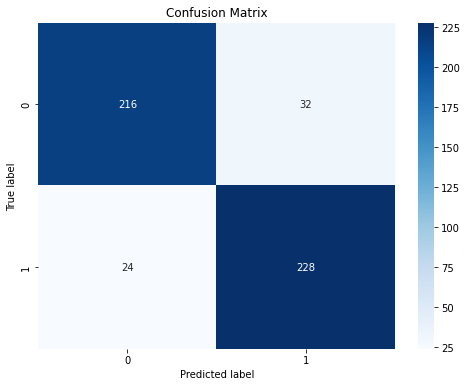

In [ ]:
plt.figure(figsize=(8,6))
ConfMatrix = confusion_matrix(test_df['label'],y_pred_xlnet)
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix")